In [1]:
NUMBER_OF_EPOCH = 50000

In [2]:
import torch
import torch.nn as nn
import pandas as pd
import preprossesing as pre
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")
    

tensor([1.], device='mps:0')


In [3]:
def prepare_model(df):

    df = pre.Standardize(df)
    df = pre.encoder(df)
    df = df.drop(['id'], axis=1)
    
    print(df)

    train, val = pre.test_validation_split(df)
    
    y_train = torch.tensor(train['price'].values, dtype=torch.float32)
    X_train = train.drop(['price'], axis=1)
    X_train = torch.tensor(X_train.values, dtype=torch.float32)
    
    y_val = torch.tensor(val['price'].values, dtype=torch.float32)
    X_val = val.drop(['price'], axis=1)
    X_val = torch.tensor(X_val.values, dtype=torch.float32)
    
    return X_train, y_train, X_val, y_val

In [4]:
# Define model
class mlp(nn.Module):
    def __init__(self):
        super(mlp, self).__init__()
        
        self.layers = nn.Sequential(
        nn.Linear(9, 512),
        nn.Dropout(0.2),
        nn.ReLU(), 
        
        nn.Linear(512, 256),
        nn.Dropout(0.2),
        nn.ReLU(),
        
        nn.Linear(256, 128),
        nn.Dropout(0.2),
        nn.ReLU(),
        
        nn.Linear(128, 64),
        nn.Dropout(0.1),
        nn.ReLU(),
        
        nn.Linear(64, 32),
        nn.ReLU(),
        
        nn.Linear(32, 1) 
        )
        
        self.manufacturers = nn.Sequential(
        nn.Linear(9, 1),
        nn.ReLU()
        )
        
        self.model = nn.Sequential(
        nn.Linear(169, 1),
        nn.ReLU()
        )
        
        self.gearbox_type = nn.Sequential(
        nn.Linear(3, 1),
        nn.ReLU()
        )
        
        self.fuel_type = nn.Sequential(
        nn.Linear(5, 1),
        nn.ReLU()
        )
        
        self.registration_fees = nn.Sequential(
        nn.Linear(12, 1),
        nn.ReLU()
        )
        
        self.engine_capacity = nn.Sequential(
        nn.Linear(20, 1),
        nn.ReLU()
        )
        
    def forward(self, x):
        manufacutre_output = self.manufacturers(x[:, 3:12])
        model_output = self.model(x[:, 12:181])
        gearbox_output = self.gearbox_type(x[:, 181:184])
        fuel_output = self.fuel_type(x[:, 184:189])
        registration_fees_output = self.registration_fees(x[:, 189:201])
        engine_capacity_output = self.engine_capacity(x[:, 201:221])
        x = torch.cat((x[:, :3], manufacutre_output, model_output, gearbox_output, fuel_output, registration_fees_output, engine_capacity_output), 1)

        return self.layers(x)

model = mlp()
model

mlp(
  (layers): Sequential(
    (0): Linear(in_features=9, out_features=512, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): Dropout(p=0.2, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=64, bias=True)
    (10): Dropout(p=0.1, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=32, bias=True)
    (13): ReLU()
    (14): Linear(in_features=32, out_features=1, bias=True)
  )
  (manufacturers): Sequential(
    (0): Linear(in_features=9, out_features=1, bias=True)
    (1): ReLU()
  )
  (model): Sequential(
    (0): Linear(in_features=169, out_features=1, bias=True)
    (1): ReLU()
  )
  (gearbox_type): Sequential(
    (0): Linear(in_features=3, out_features=1, bias=True)
    (1): ReLU()
  )
  (fuel_type): Sequential(
    (0): Linear

In [5]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [6]:
df = pd.read_csv('data/train.csv')
X_train, y_train, X_val, y_val = prepare_model(df)

          year  operating_hours  efficiency  price    0    1    2    3    4  \
0    -0.041437        -0.920504    0.801910   8500  1.0  0.0  0.0  0.0  0.0   
1     0.893944        -0.931365   -1.713066  59812  0.0  1.0  0.0  0.0  0.0   
2     0.893944        -0.965907   -0.244320  16999  0.0  0.0  1.0  0.0  0.0   
3     0.893944        -0.919882   -1.652707  33790  0.0  0.0  0.0  1.0  0.0   
4    -1.444510        -0.467668    0.714724   5273  1.0  0.0  0.0  0.0  0.0   
...        ...              ...         ...    ...  ...  ...  ...  ...  ...   
9995  0.893944        -0.584789   -0.532704  17298  0.0  0.0  0.0  0.0  1.0   
9996 -0.041437         1.783688    1.291492  11490  0.0  0.0  0.0  0.0  1.0   
9997 -0.041437         0.071428   -0.116895  20352  0.0  1.0  0.0  0.0  0.0   
9998  1.361635        -1.005187   -0.365039  29998  0.0  0.0  0.0  1.0  0.0   
9999  0.893944        -0.992652    0.258675  15495  0.0  0.0  0.0  0.0  0.0   

        5  ...   22   23   24   25   26   27   28  

In [ ]:
import numpy as np
best_val_loss = float('inf')
training_loss = np.array([])
validation_loss = np.array([])

for n in range(NUMBER_OF_EPOCH):
    model.train()
    y_pred = model(X_train)[:, 0]
    loss = loss_fn(y_pred, y_train)
    training_loss = np.append(training_loss, loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    y_pred = model(X_val)[:, 0]
    val_loss = loss_fn(y_pred, y_val)
    validation_loss = np.append(validation_loss, val_loss.item())
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model, 'mlp_model.pth')
    
    if n % 100 == 0:
        print(f'Epoch: {n} Loss: {loss.item()}'f' Validation loss: {val_loss.item()}'f' best Validation loss: {best_val_loss}')

Epoch: 0 Loss: 382321984.0 Validation loss: 374955456.0 best Validation loss: 374955456.0
Epoch: 100 Loss: 55605520.0 Validation loss: 49220192.0 best Validation loss: 49220192.0
Epoch: 200 Loss: 32345316.0 Validation loss: 28866198.0 best Validation loss: 28556216.0
Epoch: 300 Loss: 22016064.0 Validation loss: 17947504.0 best Validation loss: 17947504.0
Epoch: 400 Loss: 17342272.0 Validation loss: 15566847.0 best Validation loss: 14104249.0
Epoch: 500 Loss: 14036540.0 Validation loss: 13692211.0 best Validation loss: 11254883.0
Epoch: 600 Loss: 12453698.0 Validation loss: 10485283.0 best Validation loss: 9795741.0
Epoch: 700 Loss: 11520979.0 Validation loss: 8928866.0 best Validation loss: 8673414.0
Epoch: 800 Loss: 11119315.0 Validation loss: 8913803.0 best Validation loss: 8467057.0
Epoch: 900 Loss: 10721811.0 Validation loss: 8987101.0 best Validation loss: 8109440.0
Epoch: 1000 Loss: 10526201.0 Validation loss: 8901585.0 best Validation loss: 7519726.0
Epoch: 1100 Loss: 10734979.0

(15970,) (15970,)


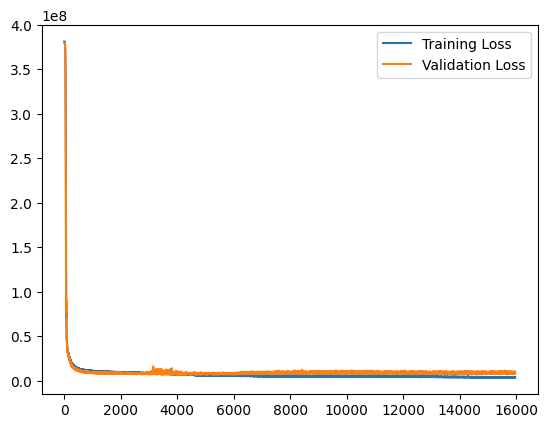

In [ ]:
import matplotlib.pyplot as plt

print(training_loss.shape, validation_loss.shape)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.legend(loc='best')

In [ ]:
df = pd.read_csv('data/test.csv')
model = torch.load('mlp_model.pth')

index = df['id']
df = df.drop(['id'], axis=1)
X = pre.encoder(df)
X = pre.standardize(X, scaler=pickle.load(open('scaler.pkl', 'rb')))
X = torch.tensor(X.values, dtype=torch.float32)
y_pred = model(X)[:, 0]

df = pd.DataFrame(y_pred.detach().numpy(), columns=['price'])
df = pd.concat([index, df], axis=1)
df.rename(columns={'price': 'answer'}, inplace=True)
df.to_csv('output.csv', index=False)

/var/folders/64/cy9kvd894_bfkfb71dsbxt2w0000gn/T/ipykernel_55830/1704775834.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('mlp_model.pth')
